# ECE570 Project: Accurate Prediction of Bounding Boxes in Object Detection

### Name: Souradip Pal
### PUID: 0034772329

This notebook contains steps to run a custom implementation of the paper "Bounding Box Regression with Uncertainty for Accurate Object Detection" by He et. al.

# Getting Started

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/pytorch/vision.git

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.


In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import time
import shutil
import os

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [5]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Load PASCAL VOC 2007 data
In order to train and evaluate object detection models, we need a dataset where each image is annotated with a *set* of *bounding boxes*, where each box gives the category label and spatial extent of some object in the image.

We will use the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which provides annotations of this form. 

The data from the 2007 challenge used to be one of the most popular datasets for evaluating object detection. It is much smaller than more recent object detection datasets such as [COCO](http://cocodataset.org/#home), and thus easier to manage.

The following function will download the PASCAL VOC 2007 dataset and return it as a PyTorch Dataset object:

In [7]:
def get_pascal_voc2007_data(image_root, download = False, split='train'):
  """
  Use torchvision.datasets
  https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCDetection
  """
  from torchvision import datasets

  train_dataset = datasets.VOCDetection(image_root, year='2007', image_set=split, download=download)
  
  return train_dataset

# Mount Drive to Load Data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following cell is used to download the training and validation sets for the PASCAL VOC 2007 dataset:

In [9]:
# uncomment below to use the mirror link if the original link is broken
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
train_dataset = get_pascal_voc2007_data('/content/drive/MyDrive/ECE570/project', True, 'train')
val_dataset = get_pascal_voc2007_data('/content/drive/MyDrive/ECE570/project', True, 'val')

# an example on the raw annotation
import json
print(json.dumps(train_dataset[1][1]['annotation'], indent=2))

{
  "folder": "VOC2007",
  "filename": "000017.jpg",
  "source": {
    "database": "The VOC2007 Database",
    "annotation": "PASCAL VOC2007",
    "image": "flickr",
    "flickrid": "228217974"
  },
  "owner": {
    "flickrid": "genewolf",
    "name": "whiskey kitten"
  },
  "size": {
    "width": "480",
    "height": "364",
    "depth": "3"
  },
  "segmented": "0",
  "object": [
    {
      "name": "person",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "185",
        "ymin": "62",
        "xmax": "279",
        "ymax": "199"
      }
    },
    {
      "name": "horse",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "90",
        "ymin": "78",
        "xmax": "403",
        "ymax": "336"
      }
    }
  ]
}


# Creating custom dataset
We need to preprocess the image, converting it to a PyTorch tensor and resizing it to 224x224. Also the target annotations are converted into COCO format.

In [10]:
from torchvision import transforms

class PascalDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, width, height, transforms=None):
        self.transforms = transforms
        self.dataset = dataset
        self.height = height
        self.width = width

        self.class_to_idx = {'_background': 0, 'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5,
                'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10, 'diningtable':11,
                'dog':12, 'horse':13, 'motorbike':14, 'person':15, 'pottedplant':16,
                'sheep':17, 'sofa':18, 'train':19, 'tvmonitor':20
        }

        self.idx_to_class = {i:c for c, i in self.class_to_idx.items()}

    def __getitem__(self, idx):

        img, ann = self.dataset[idx]
        img = np.array(img)

        # reading the images and converting them to correct size and color    
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        boxes = []
        labels = []
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        image_id = int(ann['annotation']['filename'].split('.')[0])
        all_bbox = ann['annotation']['object']
        if type(all_bbox) == dict: # inconsistency in the annotation file
          all_bbox = [all_bbox]
        
        bboxes = []
        labels= []
        for bbox_idx, one_bbox in enumerate(all_bbox):
          bbox = one_bbox['bndbox']
          obj_cls = one_bbox['name']

          # bounding box
          xmin = float(bbox['xmin'])
          xmax = float(bbox['xmax'])
          
          ymin = float(bbox['ymin'])
          ymax = float(bbox['ymax'])

          xmin_corr = (xmin/wt)*self.width
          xmax_corr = (xmax/wt)*self.width
          ymin_corr = (ymin/ht)*self.height
          ymax_corr = (ymax/ht)*self.height
          bboxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          labels.append(self.class_to_idx[obj_cls])

        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(bboxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowded
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([image_id])
        target["image_id"] = image_id


        if self.transforms:
            sample = self.transforms(img_res)
            img_res = sample
            
        return img_res, target

    def __len__(self):
        return len(self.dataset)

In [11]:
reshape_size = 224
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((reshape_size, reshape_size)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# check dataset
voc_dataset = PascalDataset(train_dataset, reshape_size, reshape_size, preprocess)
print('length of dataset = ', len(voc_dataset), '\n')

voc_dataset_val = PascalDataset(val_dataset, reshape_size, reshape_size, preprocess)
print('length of dataset = ', len(voc_dataset_val), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = voc_dataset[24]
print(img.shape, '\n',target)

length of dataset =  2501 

length of dataset =  2510 

torch.Size([3, 224, 224]) 
 {'boxes': tensor([[ 16.9768,   9.3333, 202.7789, 221.2000]]), 'labels': tensor([8]), 'area': tensor([39365.2734]), 'iscrowd': tensor([0]), 'image_id': tensor([122])}


In [12]:
from engine import train_one_epoch, evaluate
import utils

dataset = PascalDataset(train_dataset, reshape_size, reshape_size, preprocess)
dataset_val = PascalDataset(val_dataset, reshape_size, reshape_size, preprocess)

######### Smaller subset of dataset for testing ##############
# dataset = PascalDataset(torch.utils.data.Subset(train_dataset, torch.arange(0, 500)), reshape_size, reshape_size, preprocess)
# dataset_val = PascalDataset(torch.utils.data.Subset(val_dataset, torch.arange(0, 250)), reshape_size, reshape_size, preprocess)

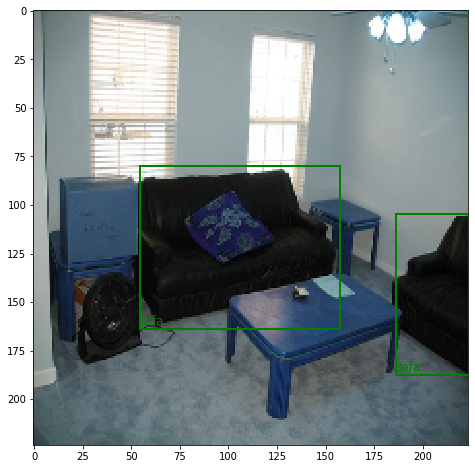

In [13]:
# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class_to_idx = {'_background': 0, 'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5,
        'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10, 'diningtable':11,
        'dog':12, 'horse':13, 'motorbike':14, 'person':15, 'pottedplant':16,
        'sheep':17, 'sofa':18, 'train':19, 'tvmonitor':20
}

idx_to_class = {i:c for c, i in class_to_idx.items()}

def plot_img_bbox(img, target, path):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(8,8)
    img = img.cpu()
    a.imshow(img.permute(1,2,0))
    if 'scores' in target:
      for idx, (box, score, label) in enumerate(zip(target['boxes'], target['scores'], target['labels'])):
          x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
          x, y, width, height = x.cpu(), y.cpu(), width.cpu(), height.cpu()
          rect = patches.Rectangle((x, y),
                                  width, height,
                                  linewidth = 2,
                                  edgecolor = 'g',
                                  facecolor = 'none')

          # Draw the bounding box on top of the image
          a.add_patch(rect)
          
          # Add info to boxes
          posx = x/img.shape[1]
          posy = 1.0 - (y+height)/img.shape[2]
          label = label.cpu()
          class_name = idx_to_class[label.item()]
          score = score.cpu()
          print(f'Object #{idx} - Label: {class_name}, Score: {score:.2f}')

          a.text(posx, posy, f'{class_name},{score:.1f}',
              verticalalignment='bottom', horizontalalignment='left',
              transform=a.transAxes, color='green', fontsize=12)
      plt.savefig(path)
      plt.show()
    else:
      for box, label in zip(target['boxes'], target['labels']):
          x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
          x, y, width, height = x.cpu(), y.cpu(), width.cpu(), height.cpu()
          rect = patches.Rectangle((x, y),
                                  width, height,
                                  linewidth = 2,
                                  edgecolor = 'g',
                                  facecolor = 'none')

          # Draw the bounding box on top of the image
          a.add_patch(rect)
          
          # Add info to boxes
          posx = x/img.shape[1]
          posy = 1.0 - (y+height)/img.shape[2]
          label = label.cpu()
          class_name = idx_to_class[label.item()]

          a.text(posx, posy, f'{class_name}',
              verticalalignment='bottom', horizontalalignment='left',
              transform=a.transAxes, color='green', fontsize=12)
      plt.savefig(path)
      plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = voc_dataset_val[24]
plot_img_bbox(img, target, "/content/drive/MyDrive/ECE570/project/input.png")

## Create Data Loaders

In [14]:
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

val_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=16, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [15]:
train_loader_iter = iter(train_loader)
img, target = train_loader_iter.next()

print('img has length: ', len(img))
print('target has length: ', len(target))

print('Image 1 has only two annotated objects:')
print(target[0])

print('\nEach row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')

img has length:  16
target has length:  16
Image 1 has only two annotated objects:
{'boxes': tensor([[ 73.4720,  24.2162, 172.9280, 224.0000],
        [ 24.1920, 174.2222,  54.2080, 213.9099],
        [ 30.0160, 167.4955,  43.0080, 180.9489]]), 'labels': tensor([15, 15, 20]), 'area': tensor([19869.6953,  1191.2655,   174.7871]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([2514])}

Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).


## Loss Function


### Smooth L1 Loss for regression


In [16]:
def smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0):    
    sigma_2 = sigma**2
    box_diff = bbox_pred - bbox_targets
    in_box_diff = bbox_inside_weights*box_diff
    abs_in_box_diff = torch.abs(in_box_diff)
    smoothL1_sign = (abs_in_box_diff < 1. / sigma_2).detach().float()
    loss_box = (torch.pow(in_box_diff, 2)*(sigma_2 / 2.)*smoothL1_sign + (abs_in_box_diff - (0.5 / sigma_2))*(1. - smoothL1_sign))*bbox_outside_weights
    return loss_box.sum() / loss_box.shape[0]

### KL Loss for bounding box regression

In [17]:
def kl_loss(bbox_pred, bbox_targets, bbox_pred_std, bbox_inside_weights=1.0, bbox_outside_weights=1.0, sigma=1.0):
    sigma_2 = sigma**2
    box_diff = bbox_pred - bbox_targets
    in_box_diff = bbox_inside_weights*box_diff #bbox_inw = in_box_diff
    bbox_l1abs = torch.abs(in_box_diff)  #abs_in_box_diff = bbox_l1abs
    smoothL1_sign = (bbox_l1abs < 1. / sigma_2).detach().float()  #1 if bbox_l1abs<1 else 0 
    bbox_inws = (torch.pow(in_box_diff, 2)*(sigma_2 / 2.)*smoothL1_sign
                + (bbox_l1abs - (0.5 / sigma_2))*(1. - smoothL1_sign)) 
    bbox_inws = bbox_inws.detach().float() 
    scale = 1
    bbox_pred_std_abs_log = bbox_pred_std*0.5*scale
    bbox_pred_std_nabs = -1.*bbox_pred_std
    bbox_pred_std_nexp = torch.exp(bbox_pred_std_nabs)
    bbox_inws_out = bbox_pred_std_nexp * bbox_inws
    bbox_pred_std_abs_logw = bbox_pred_std_abs_log*bbox_outside_weights
    bbox_pred_std_abs_logwr = torch.mean(bbox_pred_std_abs_logw, dim = 0)
    
    loss_bbox = smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_pred_std_nexp)
    bbox_pred_std_abs_logw_loss = torch.sum(bbox_pred_std_abs_logwr)
    bbox_inws_out = bbox_inws_out*scale
    bbox_inws_outr = torch.mean(bbox_inws_out, dim = 0)
    bbox_pred_std_abs_mulw_loss = torch.sum(bbox_inws_outr)
    return (loss_bbox + bbox_pred_std_abs_logw_loss + bbox_pred_std_abs_mulw_loss)

### Object classifiction

### Some Helper Functions

In [18]:
import torch

@torch.no_grad()
def rel_error(pred, true, eps=1e-8):
  return ((pred-true).abs() / true.abs().clamp(min=eps)).max().item()

In [19]:
import random

def fix_random_seed(seed_no=0):
  torch.manual_seed(seed_no)
  torch.cuda.manual_seed(seed_no)
  random.seed(seed_no)

In [20]:
# sanity check
fix_random_seed(0)
pred = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)

loss1 = F.smooth_l1_loss(pred, target, beta=1., reduction = 'sum') / pred.shape[0]
loss2 = smooth_l1_loss(pred, target, 1, 1)

print('error: ', rel_error(loss1, loss2))

error:  0.0


# Train an object detector

## Object detection module

A pretrained model for Faster-RCNN-Resnet50-FPN is used.

In [21]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
original_model = fasterrcnn_resnet50_fpn(weights=weights)

In [22]:
original_model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

In [23]:
def weights_init_normal(m):
    # for every Linear layer in a model
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(0.0, 0.0001)
        m.bias.data.fill_(0)

## Box Predictor without KL Loss

In [24]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.cls_score = nn.Linear(in_channels, num_classes,  bias=True)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4,  bias=True)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

## Box Predictor with KL Loss

In [25]:
class FastRCNNPredictorKL(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.cls_score = nn.Linear(in_channels, num_classes,  bias=True)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4,  bias=True)
        self.bbox_std = nn.Linear(in_channels, num_classes * 4,  bias=True)
        self.bbox_std.apply(weights_init_normal)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        bbox_stds = self.bbox_std(x)

        return scores, bbox_deltas, bbox_stds

In [26]:
def fastrcnn_loss(class_logits, box_regression, labels, regression_targets, box_variance = None):
    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)

    classification_loss = F.cross_entropy(class_logits, labels)

    # get indices that correspond to the regression targets for
    # the corresponding ground truth labels, to be used with
    # advanced indexing
    sampled_pos_inds_subset = torch.where(labels > 0)[0]
    labels_pos = labels[sampled_pos_inds_subset]
    N, num_classes = class_logits.shape
    box_regression = box_regression.reshape(N, box_regression.size(-1) // 4, 4)

    if not box_variance is None:
      box_variance = box_variance.reshape(N, box_variance.size(-1) // 4, 4)
      box_loss = kl_loss(box_regression[sampled_pos_inds_subset, labels_pos], 
          regression_targets[sampled_pos_inds_subset], 
          box_variance[sampled_pos_inds_subset, labels_pos], 
          bbox_inside_weights = 1.0, 
          bbox_outside_weights = 1.0,
          sigma = 3.0
      )
    else:
      box_loss = F.smooth_l1_loss(
          box_regression[sampled_pos_inds_subset, labels_pos],
          regression_targets[sampled_pos_inds_subset],
          beta=1 / 9,
          reduction="sum",
      )
      box_loss = box_loss / labels.numel()

    return classification_loss, box_loss

Implemention of the `forward` function of RoIHeads module of the detector. Modification done to original [roi_heads](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py) module in Pytorch.

In [27]:
from torchvision.ops import boxes as box_ops, roi_align

class RoIHeadsKL(torchvision.models.detection.roi_heads.RoIHeads):

    def __init__(self, model, num_classes, cfg=None):
        super(RoIHeadsKL, self).__init__(
            model.roi_heads.box_roi_pool,
            model.roi_heads.box_head,
            #model.roi_heads.box_predictor,
            FastRCNNPredictorKL(in_channels=1024, num_classes=num_classes),
            
            # Faster R-CNN training
            model.roi_heads.proposal_matcher.high_threshold,
            model.roi_heads.proposal_matcher.low_threshold,
            model.roi_heads.fg_bg_sampler.batch_size_per_image,
            model.roi_heads.fg_bg_sampler.positive_fraction,
            model.roi_heads.box_coder.weights,
            # Faster R-CNN inference
            model.roi_heads.score_thresh,
            model.roi_heads.nms_thresh,
            model.roi_heads.detections_per_img
        )

        self.num_classes = num_classes

        # soft nms params
        self.softnms = cfg['softnms'] if not cfg is None else False
        self.softnms_sigma=0.5

        # variance vote params
        self.var_vote = cfg['var_vote'] if not cfg is None else False
        self.var_sigma_t=0.02

    def postprocess_detections_kl(
        self,
        class_logits,
        box_regression,
        proposals,
        image_shapes,
        box_variance
    ):
        device = class_logits.device
        num_classes = class_logits.shape[-1]

        boxes_per_image = [boxes_in_image.shape[0] for boxes_in_image in proposals]
        pred_boxes = self.box_coder.decode(box_regression, proposals)
        pred_boxes_var = self.box_coder.decode(box_variance, proposals)
        
        pred_scores = F.softmax(class_logits, -1)

        pred_boxes_list = pred_boxes.split(boxes_per_image, 0)
        pred_boxes_var_list = pred_boxes_var.split(boxes_per_image, 0)
        pred_scores_list = pred_scores.split(boxes_per_image, 0)

        all_boxes = []
        all_scores = []
        all_labels = []
        for boxes, boxes_var, scores, image_shape in zip(pred_boxes_list, pred_boxes_var_list, pred_scores_list, image_shapes):
            boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

            # create labels for each prediction
            labels = torch.arange(num_classes, device=device)
            labels = labels.view(1, -1).expand_as(scores)

            # remove predictions with the background label
            boxes = boxes[:, 1:]
            boxes_var = boxes_var[:, 1:]
            scores = scores[:, 1:]
            labels = labels[:, 1:]

            # var-voting
            if self.var_vote:
                boxes, scores, labels = self.kl_nms(boxes, scores, self.score_thresh, self.nms_thresh, self.detections_per_img, boxes_var)
            else:
                # batch everything, by making every class prediction be a separate instance
                boxes = boxes.reshape(-1, 4)
                boxes_var = boxes_var.reshape(-1, 4)
                scores = scores.reshape(-1)
                labels = labels.reshape(-1)

                # remove low scoring boxes
                inds = torch.where(scores > self.score_thresh)[0]
                boxes, boxes_var, scores, labels = boxes[inds], boxes_var[inds], scores[inds], labels[inds]

                # remove empty boxes
                keep = box_ops.remove_small_boxes(boxes, min_size=1e-2)
                boxes, boxes_var, scores, labels = boxes[keep], boxes_var[keep], scores[keep], labels[keep]

                # non-maximum suppression, independently done per class
                keep = box_ops.batched_nms(boxes, scores, labels, self.nms_thresh)
                
                # keep only topk scoring predictions
                keep = keep[: self.detections_per_img]
                boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)

        return all_boxes, all_scores, all_labels

    def kl_nms(self, bboxes, scores, score_thresh, nms_thresh, max_num, bboxes_var=None):
        bboxes = bboxes.view(-1, self.num_classes - 1, 4)
        scores = scores.view(-1, self.num_classes - 1)
        if not bboxes_var is None:
            bboxes_var = bboxes_var.view(-1, self.num_classes - 1, 4)

        def compute_iou(boxes1, boxes2):
            """
            compute IoU between boxes1 and boxes2
            """
            iou = box_ops.box_iou(boxes1, boxes2).reshape(-1)
            return iou

        def nms_class(cls_boxes, nms_iou):
            """
            Var-Voting algorithm of the original paper
            """
            assert cls_boxes.shape[1] == 5 or cls_boxes.shape[1] == 9
            keep = []
            while cls_boxes.shape[0] > 0:
                # get bbox with max score
                max_idx = torch.argmax(cls_boxes[:, 4])
                max_box = cls_boxes[max_idx].unsqueeze(0)

                # compute iou between max_box and other bboxes
                cls_boxes = torch.cat((cls_boxes[:max_idx], cls_boxes[max_idx + 1:]), 0)
                iou = compute_iou(max_box[:, :4], cls_boxes[:, :4])

                # KL var voting
                if self.var_vote and not bboxes_var is None:
                    # get overlpapped bboxes
                    iou_mask = iou > 0
                    kl_bboxes = cls_boxes[iou_mask]
                    kl_bboxes = torch.cat((kl_bboxes, max_box), dim=0)
                    kl_ious = iou[iou_mask]
                    
                    # recover variance to sigma^2
                    kl_var = kl_bboxes[:, -4:]
                    kl_var = torch.exp(kl_var)

                    # compute weighted bbox
                    p_i = torch.exp(-1*torch.pow((1 - kl_ious), 2) / self.var_sigma_t)
                    p_i = torch.cat((p_i, torch.ones(1).to(cls_boxes.device)), 0).unsqueeze(1)
                    p_i = p_i / kl_var
                    p_i = p_i / p_i.sum(dim=0)
                    max_box[0, :4] = (p_i * kl_bboxes[:, :4]).sum(dim=0)
                keep.append(max_box)

                # apply soft-NMS
                weight = torch.ones_like(iou)
                if not self.softnms:
                    weight[iou > nms_iou] = 0
                else:
                    weight = torch.exp(-1.0*(iou**2 / self.softnms_sigma))
                cls_boxes[:, 4] = cls_boxes[:, 4]*weight
                
                # filter bboxes with low scores
                filter_idx = (cls_boxes[:, 4] >= score_thresh).nonzero().squeeze(-1)
                cls_boxes = cls_boxes[filter_idx]
            return torch.cat(keep, 0).to(cls_boxes.device)

        # perform NMS
        output_boxes, output_scores, output_labels = [], [], []
        for i in range(self.num_classes - 1):
            filter_idx = (scores[:, i] >= score_thresh).nonzero().squeeze(-1)
            if len(filter_idx) == 0:
                continue

            filter_boxes = bboxes[filter_idx, i]
            filter_scores = scores[:, i][filter_idx].unsqueeze(1)
            if not bboxes_var is None:
                filter_boxes_var = bboxes_var[filter_idx, i]
                out_bboxes = nms_class(torch.cat((filter_boxes, filter_scores, filter_boxes_var), 1), nms_thresh)
            else:
                out_bboxes = nms_class(torch.cat((filter_boxes, filter_scores), 1), nms_thresh)
            
            if out_bboxes.shape[0] > 0:
                output_boxes.append(out_bboxes[:, :4])
                output_scores.append(out_bboxes[:, 4])
                output_labels.extend([torch.ByteTensor([i+1]) for _ in range(len(out_bboxes))])

        # output results
        if len(output_boxes) == 0:
            return torch.empty(0,4).to(bboxes.device), torch.empty(0).to(scores.device), torch.empty(0).to(scores.device)
        else:
            output_boxes, output_scores, output_labels = torch.cat(output_boxes), torch.cat(output_scores), torch.cat(output_labels)

            # sort prediction
            sort_inds = torch.argsort(output_scores, descending=True)
            output_boxes, output_scores, output_labels = output_boxes[sort_inds], output_scores[sort_inds], output_labels[sort_inds]
            
            output_boxes = output_boxes[:max_num]
            output_scores = output_scores[:max_num]
            output_labels = output_labels[:max_num]
            return output_boxes, output_scores, output_labels

    def forward(self, features, proposals, image_shapes, targets=None):
        if targets is not None:
            for t in targets:
                floating_point_types = (torch.float, torch.double, torch.half)
                if not t["boxes"].dtype in floating_point_types:
                    raise TypeError(f"target boxes must of float type, instead got {t['boxes'].dtype}")
                if not t["labels"].dtype == torch.int64:
                    raise TypeError(f"target labels must of int64 type, instead got {t['labels'].dtype}")

        if self.training:
            proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
        else:
            labels = None
            regression_targets = None
            matched_idxs = None

        box_features = self.box_roi_pool(features, proposals, image_shapes)
        box_features = self.box_head(box_features)
        class_logits, box_regression, box_variance = self.box_predictor(box_features)

        result = []
        losses = {}
        if self.training:
            if labels is None:
                raise ValueError("labels cannot be None")
            if regression_targets is None:
                raise ValueError("regression_targets cannot be None")
            
            loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets, box_variance)
            losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
        else:
            if not box_variance is None and (self.var_vote or self.softnms):
              boxes, scores, labels = self.postprocess_detections_kl(class_logits, box_regression, proposals, image_shapes, box_variance)
            else:
              boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    {
                        "boxes": boxes[i],
                        "labels": labels[i],
                        "scores": scores[i],
                    }
                )

        return result, losses

In [28]:
import os
def get_model(use_kl_loss = False, model_path = None, cfg=None):
    num_classes = 21
    in_features = 1024
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    if use_kl_loss:
        model.roi_heads = RoIHeadsKL(model, num_classes, cfg)
    else:
        model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=num_classes)
    
    if not model_path is None:
        if(os.path.exists(model_path)):
            model.load_state_dict(torch.load(model_path))
        else:
            print(f"Model path {model_path} does not exist.")
    return model

## Object Detection Trainer

## Train the net


In [29]:
def freeze_layers(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.roi_heads.box_predictor.parameters():
        param.requires_grad = True

In [30]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [31]:
def train_model(model, train_loader, val_loader, lr = 0.005, num_epochs=10):
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr,
                                momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    # let's train it for 10 epochs
    model = model.to(device)
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_loader, device=device)

In [32]:
model_without_kl = get_model(False, cfg=None)
freeze_layers(model_without_kl)
count_parameters(model_without_kl)

107625

In [32]:
model_without_kl.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=21, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=84, bias=True)
  )
)

In [ ]:
train_model(model_without_kl, train_loader=train_loader, val_loader=val_loader, num_epochs=10)

In [ ]:
torch.save(model_without_kl.state_dict(), "/content/drive/MyDrive/ECE570/project/model_w_without_kl.pth")

## Train model with KL Loss

In [ ]:
model_with_kl = get_model(True, cfg=None)
freeze_layers(model_with_kl)
count_parameters(model_with_kl)

193725

In [ ]:
train_model(model_with_kl, train_loader=train_loader, val_loader=val_loader, num_epochs=10)

Epoch: [0]  [  0/157]  eta: 0:45:36  lr: 0.000037  loss: 9.7928 (9.7928)  loss_classifier: 3.1104 (3.1104)  loss_box_reg: 6.6584 (6.6584)  loss_objectness: 0.0113 (0.0113)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 17.4321  data: 9.7879  max mem: 6993
Epoch: [0]  [ 10/157]  eta: 0:12:43  lr: 0.000357  loss: 9.3875 (9.2752)  loss_classifier: 2.9510 (2.7717)  loss_box_reg: 6.4522 (6.4602)  loss_objectness: 0.0264 (0.0290)  loss_rpn_box_reg: 0.0128 (0.0142)  time: 5.1951  data: 3.4415  max mem: 6993
Epoch: [0]  [ 20/157]  eta: 0:11:05  lr: 0.000677  loss: 7.7152 (8.0939)  loss_classifier: 1.5360 (1.8120)  loss_box_reg: 6.1916 (6.2441)  loss_objectness: 0.0214 (0.0246)  loss_rpn_box_reg: 0.0121 (0.0133)  time: 4.2292  data: 3.0651  max mem: 6993
Epoch: [0]  [ 30/157]  eta: 0:10:02  lr: 0.000998  loss: 6.3455 (7.5002)  loss_classifier: 0.5261 (1.4068)  loss_box_reg: 5.7529 (6.0538)  loss_objectness: 0.0204 (0.0257)  loss_rpn_box_reg: 0.0118 (0.0138)  time: 4.5019  data: 3.3294  max mem: 6993

In [ ]:
torch.save(model_with_kl.state_dict(), "/content/drive/MyDrive/Purdue/ECE570/project/model_w_with_kl.pth")

### Re-train(if required)

In [ ]:
# model_with_kl = get_model(True,  model_path="/content/drive/MyDrive/ECE570/project/model_w_with_kl.pth", cfg = None)
# freeze_layers(model_with_kl)
# count_parameters(model_with_kl)
# train_model(model_with_kl, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

## Inference

In [33]:
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

def get_sample_prediction(model, img, target, path):
    # put the model in evaluation mode
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        
    print('predicted #boxes: ', len(prediction['labels']))
    print('real #boxes: ', len(target['labels']))

    plot_img_bbox(img, prediction, path)

predicted #boxes:  16
real #boxes:  2
Object #0 - Label: sofa, Score: 0.94
Object #1 - Label: sofa, Score: 0.92
Object #2 - Label: sofa, Score: 0.62
Object #3 - Label: sofa, Score: 0.33
Object #4 - Label: chair, Score: 0.32
Object #5 - Label: chair, Score: 0.28
Object #6 - Label: chair, Score: 0.28
Object #7 - Label: sofa, Score: 0.27
Object #8 - Label: chair, Score: 0.21
Object #9 - Label: diningtable, Score: 0.16
Object #10 - Label: tvmonitor, Score: 0.15
Object #11 - Label: chair, Score: 0.12
Object #12 - Label: chair, Score: 0.07
Object #13 - Label: chair, Score: 0.07
Object #14 - Label: tvmonitor, Score: 0.07
Object #15 - Label: sofa, Score: 0.06


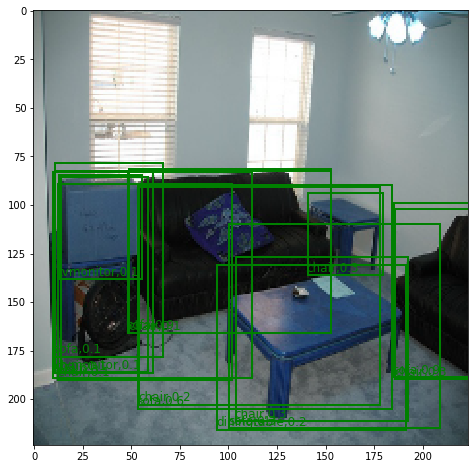

In [34]:
# pick one image from the test set
img, target = dataset_val[24]
model_without_kl = get_model(False, model_path="/content/drive/MyDrive/ECE570/project/model_w_without_kl.pth", cfg=None)
get_sample_prediction(model_without_kl, img, target, "/content/drive/MyDrive/ECE570/project/output_without_kl.png")

predicted #boxes:  12
real #boxes:  2
Object #0 - Label: sofa, Score: 0.94
Object #1 - Label: sofa, Score: 0.93
Object #2 - Label: chair, Score: 0.47
Object #3 - Label: sofa, Score: 0.40
Object #4 - Label: chair, Score: 0.34
Object #5 - Label: chair, Score: 0.31
Object #6 - Label: sofa, Score: 0.25
Object #7 - Label: chair, Score: 0.24
Object #8 - Label: chair, Score: 0.15
Object #9 - Label: tvmonitor, Score: 0.13
Object #10 - Label: diningtable, Score: 0.13
Object #11 - Label: sofa, Score: 0.07


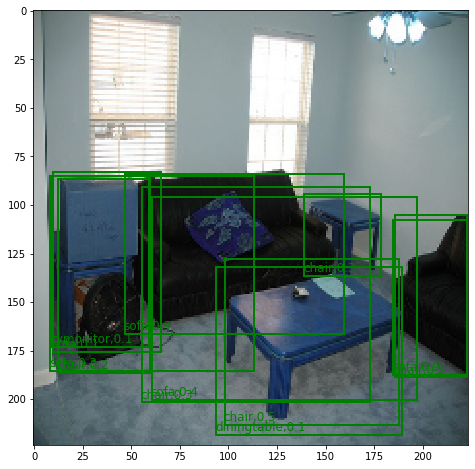

In [35]:
model_with_kl = get_model(True,  model_path="/content/drive/MyDrive/ECE570/project/model_w_with_kl.pth", cfg = None)
get_sample_prediction(model_with_kl, img, target, "/content/drive/MyDrive/ECE570/project/output_with_kl.png")

In [36]:
cfg = {}
cfg['softnms'] = False
cfg['var_vote'] = True
model_with_kl_varvote = get_model(True, model_path="/content/drive/MyDrive/ECE570/project/model_w_with_kl.pth", cfg = cfg)

In [37]:
cfg = {}
cfg['softnms'] = True
cfg['var_vote'] = True
model_with_kl_varvote_softnms = get_model(True, model_path="/content/drive/MyDrive/ECE570/project/model_w_with_kl.pth", cfg = cfg)

predicted #boxes:  12
real #boxes:  2
Object #0 - Label: sofa, Score: 0.94
Object #1 - Label: sofa, Score: 0.93
Object #2 - Label: chair, Score: 0.47
Object #3 - Label: sofa, Score: 0.40
Object #4 - Label: chair, Score: 0.34
Object #5 - Label: chair, Score: 0.31
Object #6 - Label: sofa, Score: 0.25
Object #7 - Label: chair, Score: 0.24
Object #8 - Label: chair, Score: 0.15
Object #9 - Label: tvmonitor, Score: 0.13
Object #10 - Label: diningtable, Score: 0.13
Object #11 - Label: sofa, Score: 0.07


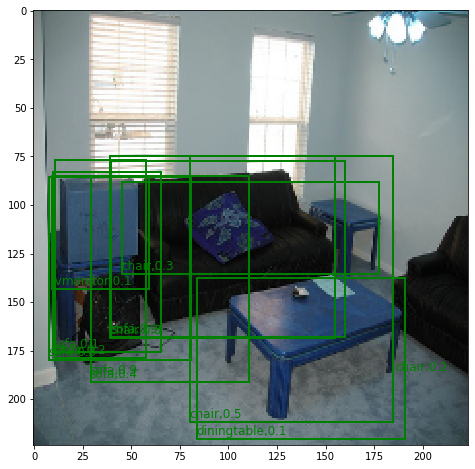

In [38]:
get_sample_prediction(model_with_kl_varvote, img, target, "/content/drive/MyDrive/ECE570/project/output_with_kl_varvote.png")

predicted #boxes:  16
real #boxes:  2
Object #0 - Label: sofa, Score: 0.94
Object #1 - Label: sofa, Score: 0.93
Object #2 - Label: chair, Score: 0.47
Object #3 - Label: chair, Score: 0.34
Object #4 - Label: sofa, Score: 0.31
Object #5 - Label: chair, Score: 0.24
Object #6 - Label: chair, Score: 0.23
Object #7 - Label: sofa, Score: 0.23
Object #8 - Label: sofa, Score: 0.18
Object #9 - Label: chair, Score: 0.15
Object #10 - Label: tvmonitor, Score: 0.13
Object #11 - Label: diningtable, Score: 0.13
Object #12 - Label: sofa, Score: 0.12
Object #13 - Label: chair, Score: 0.09
Object #14 - Label: sofa, Score: 0.08
Object #15 - Label: tvmonitor, Score: 0.06


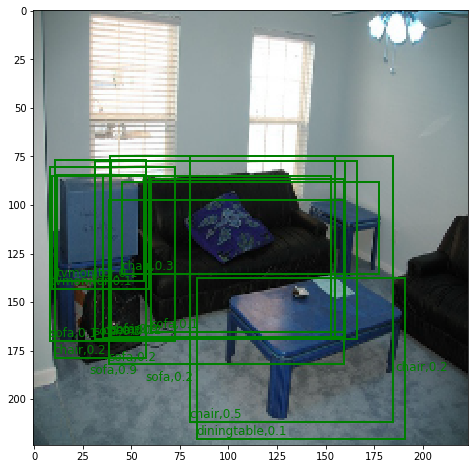

In [39]:
get_sample_prediction(model_with_kl_varvote_softnms, img, target, "/content/drive/MyDrive/ECE570/project/output_with_kl_varvote_softnms.png")

## Evaluation
Compute mean Average Precision (mAP)

In [40]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def getmAP(model, data_loader):
  cpu_device = torch.device('cpu')
  
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    for images, targets in data_loader:
      imgs = list(img.to(device) for img in images)
      outputs = model(imgs)
      outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

      metric = MeanAveragePrecision()
      metric.update(outputs, targets)
      print(metric.compute())

In [41]:
small_dataset_val = PascalDataset(torch.utils.data.Subset(val_dataset, torch.arange(0, 16)), reshape_size, reshape_size, preprocess)
small_val_loader = torch.utils.data.DataLoader(
    small_dataset_val, batch_size=16, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [42]:
evaluate(model_with_kl_varvote, small_val_loader, device=device)

creating index...
index created!
Test:  [0/1]  eta: 0:00:02  model_time: 1.7270 (1.7270)  evaluator_time: 0.0417 (0.0417)  time: 2.0711  data: 0.2979  max mem: 7474
Test: Total time: 0:00:02 (2.1327 s / it)
Averaged stats: model_time: 1.7270 (1.7270)  evaluator_time: 0.0417 (0.0417)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average

In [43]:
getmAP(model_with_kl_varvote, small_val_loader)

{'map': tensor(0.2440), 'map_50': tensor(0.5391), 'map_75': tensor(0.2105), 'map_small': tensor(0.3970), 'map_medium': tensor(0.1553), 'map_large': tensor(0.2963), 'mar_1': tensor(0.1643), 'mar_10': tensor(0.2928), 'mar_100': tensor(0.3000), 'mar_small': tensor(0.5278), 'mar_medium': tensor(0.1844), 'mar_large': tensor(0.3417), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}


In [44]:
evaluate(model_with_kl_varvote_softnms, small_val_loader, device=device)

creating index...
index created!
Test:  [0/1]  eta: 0:00:01  model_time: 1.6711 (1.6711)  evaluator_time: 0.0437 (0.0437)  time: 1.9923  data: 0.2723  max mem: 7474
Test: Total time: 0:00:02 (2.0517 s / it)
Averaged stats: model_time: 1.6711 (1.6711)  evaluator_time: 0.0437 (0.0437)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.543
 Average

In [45]:
getmAP(model_with_kl_varvote_softnms, small_val_loader)

{'map': tensor(0.2751), 'map_50': tensor(0.5802), 'map_75': tensor(0.2224), 'map_small': tensor(0.4074), 'map_medium': tensor(0.1776), 'map_large': tensor(0.3379), 'mar_1': tensor(0.1643), 'mar_10': tensor(0.3765), 'mar_100': tensor(0.3903), 'mar_small': tensor(0.5556), 'mar_medium': tensor(0.2582), 'mar_large': tensor(0.4083), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.)}
